# NYSE Index Time Series Analysis

<img src="https://www.marketplace.org/wp-content/uploads/2019/09/stockmarket.jpg?fit=2880%2C1621" width="500"/>

1. Problem definition

2. Acquire data

3. Data cleaning 

4. Time series Analysis for Apple Stock
- Check for stationarity with decomposition
- Which day had the most increase and which day had the most decrease


5. Classify similar stocks based on time series

## 1. Problem definition

> 1) Stock Analysis for Apple stock

> 2) Classify similar stocks based on time series

## 2. Acquire Data

In [2]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_csv("prices-split-adjusted.csv")
print(df.shape)
print(df.columns)

(851264, 7)
Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')


In [4]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## 3. Data cleaning

First let's analyze AAPL stock and do analysis on it.

In [5]:
df_apple = df[df['symbol'] == 'AAPL']

In [6]:
df_apple.shape

(1762, 7)

In [7]:
print(df_apple['date'].min())
print(df_apple['date'].max())

2010-01-04
2016-12-30


In [8]:
# change the format of the data
df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')
df_apple.head()

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_32658/3019356605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')


,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [9]:
df_apple.index = df_apple['date']
del df_apple['date']
df_apple.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


## 4. Time series Analysis for Apple Stock

### Check Stationarity

**What is Stationarity and why is it important?**

Stationarity is a way to measure if the data has structural patterns like seasonal trends. You need to check for both of these in time series data because they’re assumptions that are made by many widely used methods in time series analysis. For example, the autoregressive integrated moving average (ARIMA) method for forecasting time series assumes stationarity. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

**How to check for stationarity in our data**

1) Check visually
- line plot
- decomposition

Visually check whether there are any trends or seasonal patterns

2) Statistical Test

We will use the Dickey Fuller test. 


#### check visually
- line plot

<AxesSubplot:xlabel='date', ylabel='close'>

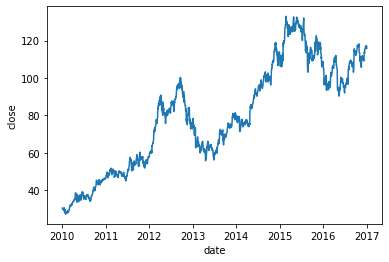

In [10]:
sns.lineplot(x=df_apple.index, y= df_apple['close'])

In [11]:
rolling_mean = df_apple['close'].rolling(90).mean()
rolling_std = df_apple['close'].rolling(90).std()

Let's overlay our time sereis with six-month rolling mean and six month rolling standard deviation.

<AxesSubplot:xlabel='date', ylabel='close'>

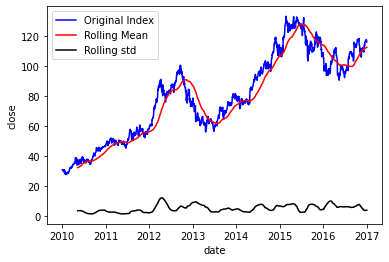

In [12]:
sns.lineplot(x=df_apple.index, y= df_apple['close'], color = 'blue', label = 'Original Index')
sns.lineplot(x=df_apple.index, y= rolling_mean, color = 'red', label = 'Rolling Mean')
sns.lineplot(x=df_apple.index, y= rolling_std, color = 'black', label = 'Rolling std')

Form above we can see that there is an increasing trend and pretty steady std.

Now let's see decompose the graph to gain further insights. For this case, we will use additive model


**When to use additive**

If the seasonality and residuals are independent of the trend in the plotted time series, we use an additive model to decompose the data. The additive time series model we are talking about is of the form: 

$O_t = T_t+S_t+R+t$ Where:

$O_t$ is the observed value.
$T_t$ is the trend value.
$S_t$ is the seasonality value.
$R_t$ is residual value.
$_t$ is a variable for a particular time indexing.

In [13]:
decompose = seasonal_decompose(df_apple['close'],model='additive', period=90)
estimated_trend_add = decompose.trend
estimated_seasonal_add = decompose.seasonal
estimated_residual_add = decompose.resid

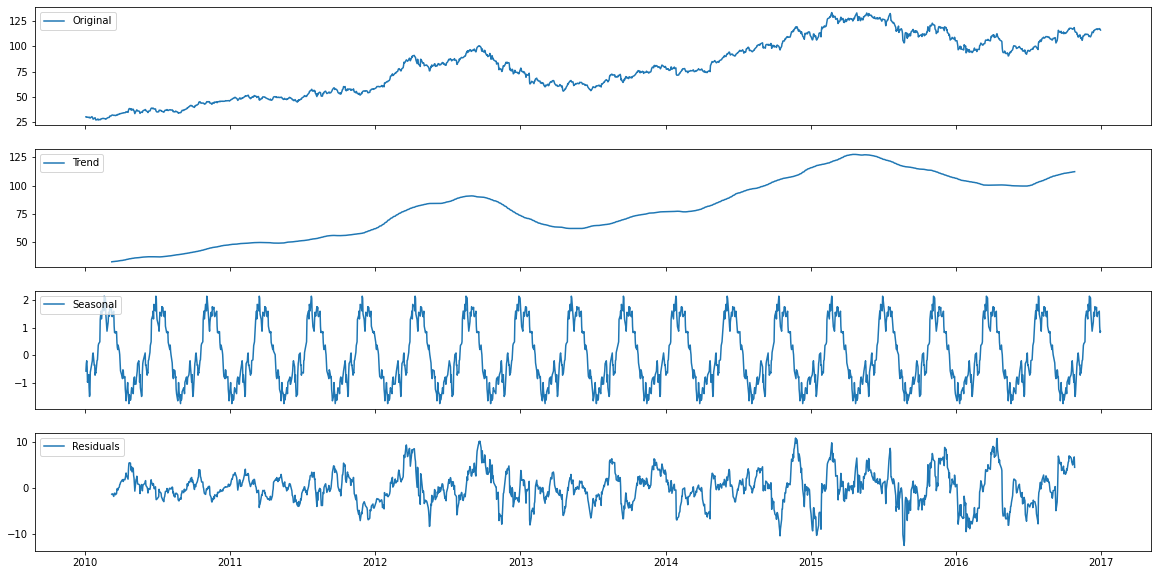

In [14]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
axes[0].plot(df_apple['close'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend_add, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal_add, label='Seasonal')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual_add, label='Residuals')
axes[3].legend(loc='upper left')


From the decompositon plot, we can see that there is definitely an increasing trend and some minor Seasonality.

#### Statistical Test
Let's import augmented Dickey-Fuller test

This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity. Stating Again,

**Null Hypothesis:** Non stationarity exists in the series.

**Alternative Hypothesis:** Stationarity exists in the series.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
# pass the data and specify the autolag parameter as "AIC"
adft = adfuller(df_apple['close'], autolag= 'AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -1.324458              Test Statistics
1     0.617910                      p-value
2     0.000000             No. of lags used
3  1761.000000  Number of observations used
4    -3.434069          critical value (1%)
5    -2.863183          critical value (5%)
6    -2.567645         critical value (10%)


First of all, from the simple line plot, we can visually see that there is an
With the above data, we can conclude that the dasta is not stationary since p > 0.05 and we accept the null hypothesis("it is not stationary")
Time series are stationary if they do not have trend or seasonal effects


From this plot, we can clearly see the increasing trend in number of passengers and the seasonality patterns in the rise and fall in values each year.


In [17]:
#How much it increased for 6 years
increase_in_6yrs = df_apple['close'][df_apple.index.max()] - df_apple['close'][df_apple.index.min()] 

In [18]:
# the day it decrease and increase the most in trems of index
df_apple['change'] = df_apple['open'] - df_apple['close']

print(df_apple['change'].min())
print(df_apple[df_apple['change'] == df_apple['change'].min()].index)
print(df_apple['change'].max())
print(df_apple[df_apple['change'] == df_apple['change'].max()].index)

-8.25
DatetimeIndex(['2015-08-24'], dtype='datetime64[ns]', name='date', freq=None)
7.370002999999997
DatetimeIndex(['2015-08-25'], dtype='datetime64[ns]', name='date', freq=None)


/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_32658/1746385401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['change'] = df_apple['open'] - df_apple['close']


In [19]:
# the day it decrease and increase the most in terms of rate
df_apple['change_rate'] = df_apple['change']/df_apple['open']
print(df_apple['change_rate'].min())
print(df_apple[df_apple['change_rate'] == df_apple['change_rate'].min()].index)
print(df_apple['change_rate'].max())
print(df_apple[df_apple['change_rate'] == df_apple['change_rate'].max()].index)

-0.08696110191964472
DatetimeIndex(['2015-08-24'], dtype='datetime64[ns]', name='date', freq=None)
0.06633068970992087
DatetimeIndex(['2015-08-25'], dtype='datetime64[ns]', name='date', freq=None)


/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_32658/2799720716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['change_rate'] = df_apple['change']/df_apple['open']


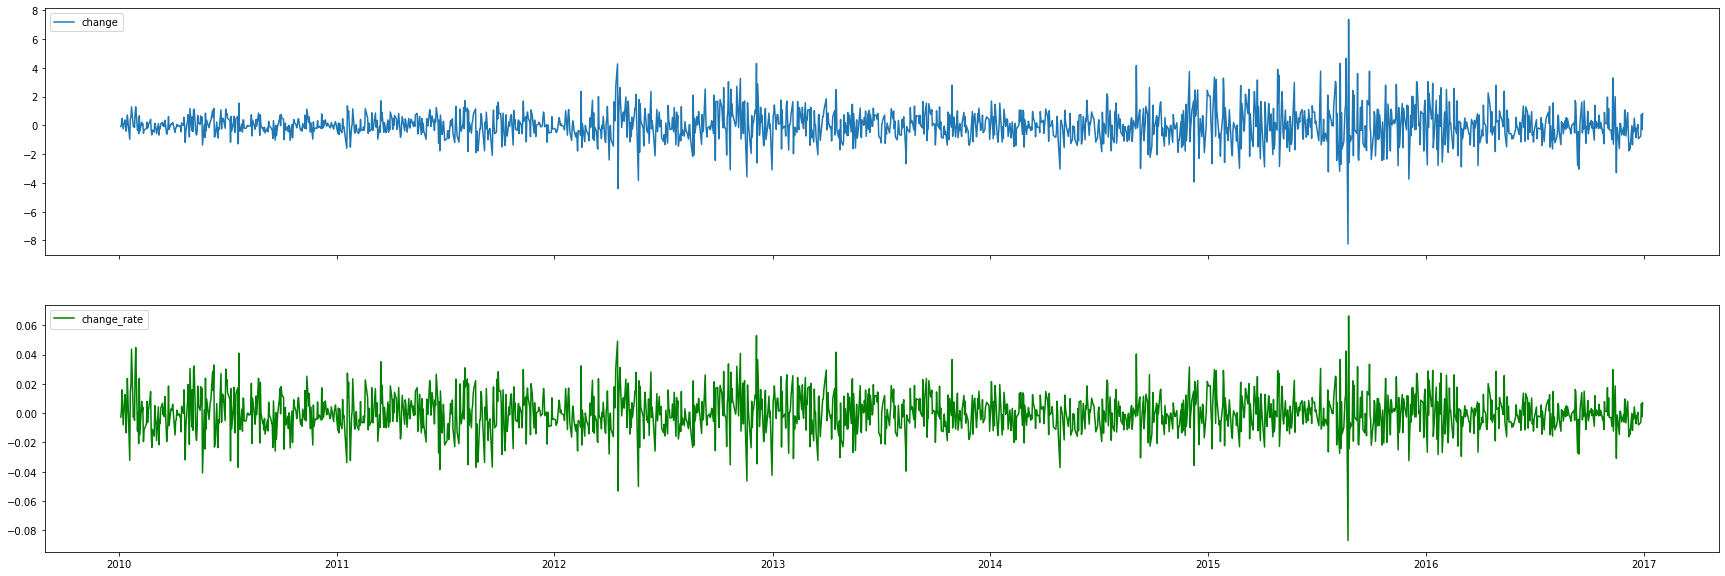

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(30)
axes[0].plot(df_apple['change'], label='change')
axes[0].legend(loc='upper left')

axes[1].plot(df_apple['change_rate'], label='change_rate', color = 'green')
axes[1].legend(loc='upper left')

let's take a look deeper on 2015-08

<AxesSubplot:xlabel='date', ylabel='open'>

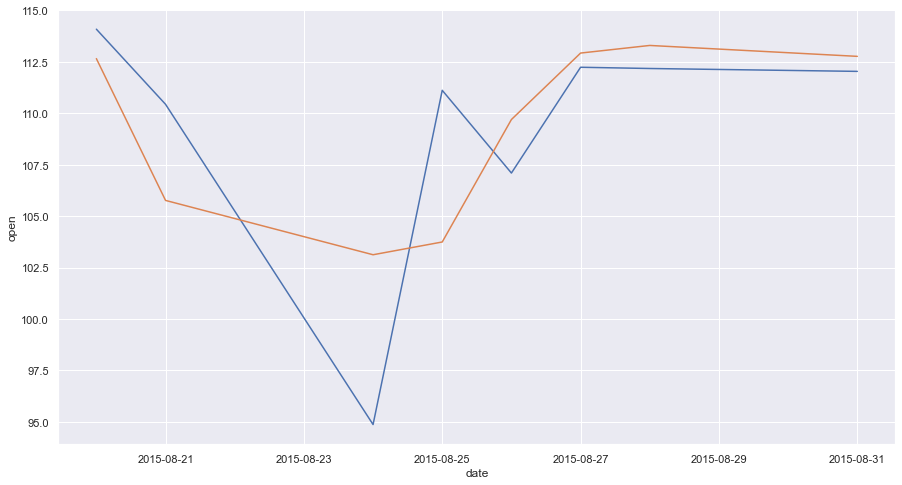

In [21]:
import datetime
df_apple_aug = df_apple.loc['2015-8-20':'2015-8-31']
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(x=df_apple_aug.index, y= df_apple_aug['open'], legend='full')
sns.lineplot(x=df_apple_aug.index, y= df_apple_aug['close'], legend='full')

Given the apple stock trend, if we can trade once a day at right before closing, how much money are we ending up with 1 stock ?

In [42]:
df_apple['close_change'] =   df_apple['close'].shift(-1) - df_apple['close']

/var/folders/ph/yfqxnlss1ds28x8n8wzmqfg00000gn/T/ipykernel_32658/1885142278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['close_change'] =   df_apple['close'].shift(-1) - df_apple['close']


In [43]:
df_apple['close_change'] # this rate shows how much gain we will make 

date
2010-01-04    0.052856
2010-01-05   -0.487143
2010-01-06   -0.055714
2010-01-07    0.200001
2010-01-08   -0.267143
                ...   
2016-12-23    0.740005
2016-12-27   -0.500000
2016-12-28   -0.029999
2016-12-29   -0.910003
2016-12-30         NaN
Name: close_change, Length: 1762, dtype: float64

In [50]:
import datetime
# + -> + stay
# + -> - sell
# - -> + buy
# - -> - stay

start_money = df_apple['close'][0]
stock_qty = 1
stock2money = 1
cash = 1

money_flow = {'Date':[],'close' : [],'stock_qty':[],'stock2money':[],'cash' : [],'total asset': []}

for i in df_apple['close_change'].index:
    if df_apple['close_change'][i] >=0 and stock_qty !=0: # if increase tmr, and we have stock
        # stay in the stock
        print('stay in stock')
        pass

    elif df_apple['close_change'][i] >= 0 and stock_qty == 0:
        stock_qty = cash / df_apple['close'][i] # end of the day_i I bought all stock
        print(i)
        stock2money = df_apple['close'][i + datetime.timedelta(days=1)] *stock_qty
        cash = 0
        # prev is negative
        # buy the stock
        #cash -> stock

    elif df_apple['close_change'][i] < 0 and stock_qty !=0:
        # sell the stock
        stock_qty = 0 # end of the day_i I bought all stock
        stock2money = 0
        cash = stock_qty * df_apple['close'][i]

    elif df_apple['close_change'][i]<0 and stock_qty == 0:

        pass
    # print(df_apple['close_change'][i])


1
stay in stock
2010-01-07 00:00:00
2010-01-12 00:00:00
2010-01-15 00:00:00


KeyError: Timestamp('2010-01-16 00:00:00')